# Plummer sphere

The Plummer model is a widely used theoretical framework for describing the distribution of stars within globular clusters and galaxies. Proposed by H.C. Plummer in 1911, it offers a simple yet effective way to model a spherically symmetric, isotropic stellar system in equilibrium. This model is particularly useful for studying systems where gravitational interactions dominate, and it avoids the central density cusp found in other profiles, such as the Navarro-Frenk-White (NFW) model.  

Globular clusters, which are dense groups of stars orbiting the halo of galaxies, are often modeled using the Plummer profile due to their approximately spherical shape and isotropic velocity distributions. These clusters, containing thousands to millions of stars, are bound by their mutual gravitational attraction and exhibit relaxed, quasi-equilibrium states. The Plummer model's finite central density and decreasing density at large radii make it a good fit for describing the spatial distribution of stars within globular clusters.

### **Density Profile and Potential**  
The Plummer model describes the mass density, \( \rho(r) \), as a function of distance \( r \) from the center:

$$
\rho(r) = \frac{3 M}{4 \pi b^3} \left( 1 + \frac{r^2}{b^2} \right)^{-5/2}
$$

Here,  
- \( M \) is the total mass of the system.  
- \( b \) is the scale parameter, corresponding to the characteristic radius of the system.  

The corresponding gravitational potential is:

$$
\Phi(r) = -\frac{GM}{\sqrt{r^2 + b^2}}
$$

This potential leads to a finite escape velocity, ensuring that stars remain bound within the system.

The cumulative mass enclosed within a radius \( r \) is given by:

$$
M(r) = M \frac{r^3}{\left( r^2 + b^2 \right)^{3/2}}
$$


### **Distribution Function (Jeans Theory)**  
In a spherical, isotropic system, the distribution function \( f(\varepsilon) \) depends only on the binding energy \( \varepsilon \). For the Plummer model, the distribution function is:

$$
f(\varepsilon) = \frac{24\sqrt{2}}{7\pi^3} \frac{Mb^2}{(G M)^5} (-\varepsilon)^{7/2}
$$

where  
- $\varepsilon = \Psi - \frac{1}{2}v^2$ is the relative energy,  
- $\Psi = -\Phi + \Phi_0$ is the relative potential,  


### **Generating Positions**  
To generate initial positions for stars according to the Plummer profile, we use the cumulative mass distribution function:

$$
P(r) = \frac{r^3}{b^3 \left( 1 + \frac{r^2}{b^2} \right)^{3/2}}
$$

We can use a random variable \( P \) uniformly distributed between 0 and 1 to find the corresponding radius:

$$
r = b \sinh \left( \text{arctanh}\left( P^{1/3} \right) \right)
$$


### **Generating Velocities**  
The velocity distribution is determined using the fact that the Plummer model is ergodic (i.e., the distribution function depends only on the energy). For a spherical ergodic system:

$$
\nu(r) = \frac{\rho(r)}{M} = 4\pi \int_0^\Psi v^2 f\left( \Psi - \frac{1}{2} v^2 \right) dv
$$

To generate velocities:  
1. Calculate the escape velocity at radius \( r \):

$$
v_{esc} = \sqrt{2\Psi}
$$

2. Draw a velocity magnitude \( v \) from the distribution:

$$
g(q) \propto q^2 (1 - q^2)^{7/2}
$$

where $q = \frac{v}{v_{esc}}$.  

3. Assign velocity components by randomly sampling angles from an isotropic distribution.


**TREE-CODE**

This algorithm does an approximation on the force computation. 
Given N particles in a volume V, tree-code devides teh volume iteratively into cubes up to the point each one contains only 1 particle. 
When the force acting over one particle i is computed, particles sufficiently far away from it are grouped in one point (the center ??) and their mass is sum up in total mass M. This is equal to take only the first order of the multipolar expansion (monopole term).

Computational cost: $N\log(N)$

Leaf opening criterion: $\theta = r_{cell}/d < \theta_{crit}$ 

$\theta_{crit}$ is the accuracy parameter (<<1 radiant)

Gravitational softening: to avoid huge scatterings we set the force different from newtonian one if the particles get to much close:

$|f_{ij}|=\frac{Gm_im_j}{|r_i-r_j|^2+\epsilon^2}$

does not diverge: it's like the mass of each particle has been smoothed over a finite volume.

Time integration: LEAP-FROG method. $t_i -> t_{i+1}$

$v_{i+\frac{1}{2}}=v_i+(\frac{h}{2})a_i$

$r_{i+1}=r_i+hv_{i+\frac{1}{2}}$

$v_{i+1}=v_{i+\frac{1}{2}}+(\frac{h}{2})a_i$

h is NOT ADAPTIVE, it's set at imput. We will set $h<<t_{dyn}$

$\epsilon = 10^{-4}(V/N)^{1/3}$

**INTERNAL UNITS**

treecode works with internal units. $G_{iu}$ is set equal to 1. We are free to express masses and distances in arbitrary units, as far as velocities and times are consistent. In order to see that, notice that $\frac{GM}{rv^2}$ is adimensional. 

$$\frac{M_{iu}}{r_{iu}v_{iu}^2}=\frac{G_{cgs}M_{cgs}}{r_{cgs}v_{cgs}^2}$$

Velocities in internal units will be related to physical velocities by:

$$v_{iu}=\sqrt{\frac{r_{cgs}}{G_{cgs}M_{cgs}}}v_{cgs}$$

We need to tranform time units in internal units as well. $\frac{rt}{v}$ is adimensional. 

$$\frac{t_{iu}v_{iu}}{r_{iu}}=\frac{t_{cgs}v_{cgs}}{r_{cgs}}$$

$$t_{iu}=\frac{r_{iu}}{r_{cgs}}\sqrt{\frac{r_{cgs}}{G_{cgs}M_{cgs}}}t_{cgs}$$

In [1]:
from myTreecode import Star
from myTreecode import Tree
from myTreecode import grav_force_star_node
from myTreecode import evolve
from view import view
from view import show_animation
from view import sky_projection

import numpy as np
import numpy.random as random

In [2]:
### constants and internal units ###

c_cgs = 2.99792458 * 10**10 #cm/s
G_cgs = 6.67259 * 10**-8 #G in cgs
M_sun = 1.9891 * 10**33 #solar mass in g
R_sun = 6.9598 * 10**10 #solar radius in cm 
M_earth = 5.976 * 10**27 #earth mass in g
R_earth = 6.378 * 10**8 #earth radius in cm
ly = 9.463 * 10**17 #light year in cm
parsec = 3.086 * 10**18 #parsec in cm
AU = 1.496 * 10**13 #astronomical unit in cm
Sun_shw = 2*G_cgs*M_sun/(c_cgs**2) #Sun's Schwarschild radius in cgs

kB = 1.380649 * 10**-16 #erg/K

def v_IU(M_cgs, r_cgs, v_cgs):
    return np.sqrt(r_cgs/(G_cgs*M_cgs))*v_cgs

def c_IU(M_cgs, r_cgs):
    return np.sqrt(r_cgs/(G_cgs*M_cgs))*c_cgs

def t_IU(M_cgs, r_cgs, t_cgs):
    return t_cgs/(np.sqrt(r_cgs/(G_cgs*M_cgs))*r_cgs)

print("If we choose 1 solar mass as mass unit and 1 parsec unit as distance unit:")
print("1 Myr expressed in internal units is: %f" % (t_IU(M_sun,parsec,3.156*10**13)))
print("1 time unit is: %f Myrs" % (1/t_IU(M_sun,parsec,3.156*10**13)))
print("1 time unit is: %f s" % (1/t_IU(M_sun,parsec,1)))
print("Light speed expressed in internal units is: %E" % (c_IU(M_sun,parsec)))
print("Sun rest mass energy in internal units is: %E" %(1*c_IU(M_sun,parsec)))
print("Sun kinetic energy (0.5M(200km/s) = %E erg) in internal units is: %E" %(0.5*M_sun*(200*10**5)**2, 0.5*v_IU(M_sun, parsec, 200*10**5)))
print("1 km/s in internal units is: %f" %(v_IU(M_sun, parsec, 1*10**5)))

time_conversion_factor = 14.910128      # 1 Myr in internal units
energy_conversion_factor = 1/1524.834   # sun kinetic energy in internal units
velocity_conversion_factor = 15.248335  # Km/s in internal units



If we choose 1 solar mass as mass unit and 1 parsec unit as distance unit:
1 Myr expressed in internal units is: 0.067069
1 time unit is: 14.910128 Myrs
1 time unit is: 470563626066861.375000 s
Light speed expressed in internal units is: 4.571336E+06
Sun rest mass energy in internal units is: 4.571336E+06
Sun kinetic energy (0.5M(200km/s) = 3.978200E+47 erg) in internal units is: 1.524834E+03
1 km/s in internal units is: 15.248335


In [3]:

class Plummer:
    
    def __init__(self,N,b,m=1):
        self.N = int(N) 
        self.b = b 
        self.m = m 
        self.M = N*self.m 
        self.rho0 = 3*self.M/(4*np.pi*self.b**3)
 
        print(f"Plummer sphere of {self.N} stars and total mass {self.M:.2f} solar masses. "
              f"Scale parameter b is {self.b:.2f} parsecs.")

                
        self.v_typical = np.sqrt(self.M/self.b)  # from virial theorem
        self.t_cross = self.b / self.v_typical        
        self.t_relax = (0.1 * self.N / np.log(self.N)) * self.t_cross

        print(f"Characteristic velocity is {self.v_typical:.2e} in internal units, "
              f"{self.v_typical * velocity_conversion_factor:.2e} km/s. ")
        print(f"Crossing time is {self.t_cross:.2e} in internal units, "
              f"{self.t_cross * time_conversion_factor:.2e} Myr. "
              f"Relaxation time is {self.t_relax:.2e} in internal units, "
              f"{self.t_relax * time_conversion_factor:.2e} Myr.")

        # initialize system
        
        self.t = [0]
        self.system = []

        initial_conditions = []
        
        for i in range(self.N):
            
            u = random.uniform(0,1)
            v = random.uniform(0,1)
            w = random.uniform(0,1)
            r = self.b * np.sinh(np.arctanh(u**(1/3))) 
            theta = np.arccos(1-2*v) 
            phi = 2*np.pi*w
            
            x = np.array([r*np.sin(theta)*np.cos(phi),r*np.sin(theta)*np.sin(phi),r*np.cos(theta)])
            Psi_x = self.M/np.sqrt(r**2 + self.b**2)
            
            # extract a point from velocity distribution ranging from 0 to q = 1 (v = v_esc)
            norm = 7*np.pi/512   ### serve?
            while True:
                q = random.uniform(0,1) 
                y = random.uniform(0,0.093/norm) 
                if y < (1/norm) * q**2 * (1-q**2)**(7/2):
                    break
                    
            v_magn = q * np.sqrt(2*Psi_x)
            theta = np.arccos(1-2*random.uniform(0,1)) 
            phi = 2*np.pi*random.uniform(0,1)
            
            v = np.array([v_magn*np.sin(theta)*np.cos(phi),v_magn*np.sin(theta)*np.sin(phi),v_magn*np.cos(theta)])
            
            initial_conditions.append(Star(self.m, x, v))
            
        self.system.append(np.array(initial_conditions))






In [4]:
plum = Plummer(3000,10)

Plummer sphere of 3000 stars and total mass 3000.00 solar masses. Scale parameter b is 10.00 parsecs.
Characteristic velocity is 1.73e+01 in internal units, 2.64e+02 km/s. 
Crossing time is 5.77e-01 in internal units, 8.61e+00 Myr. Relaxation time is 2.16e+01 in internal units, 3.23e+02 Myr.


R covered by FOV is 24.24 pc, dr is 2.42 pc
Signal above threshold if more than 0.3 stars/bin
Saturation point when > 2991236.645474 stars/bin
Minimum velocity detectable with spectral resolution 10000.0 is 29.98 km/s


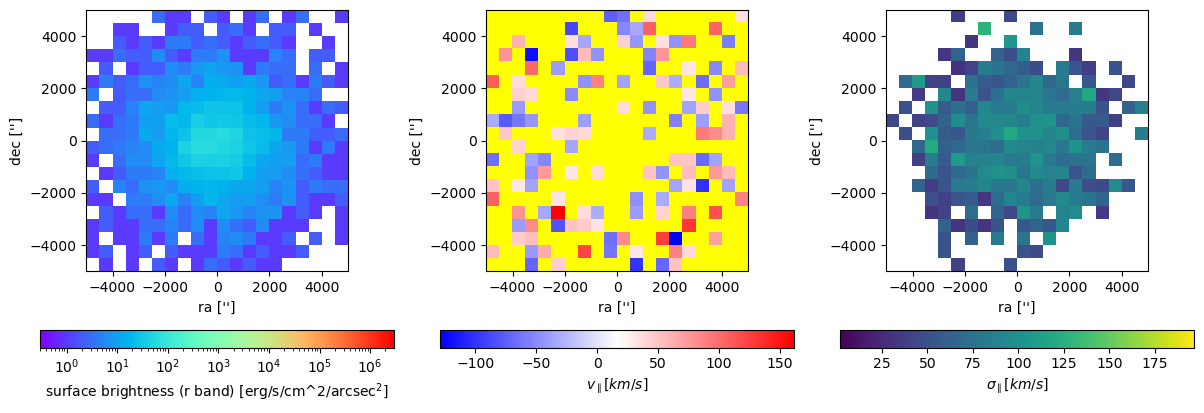

In [10]:
sky_projection(plum,time=0,distance=1000,angular_resolution=5e2,FOV=1e4,spectral_resolution=1e4)

In [ ]:

evolve(plum,tstop = 1,dt = 0.01,dtout=0.1,eps=0.001,orbit_indexes=[20,60,70,90,1])

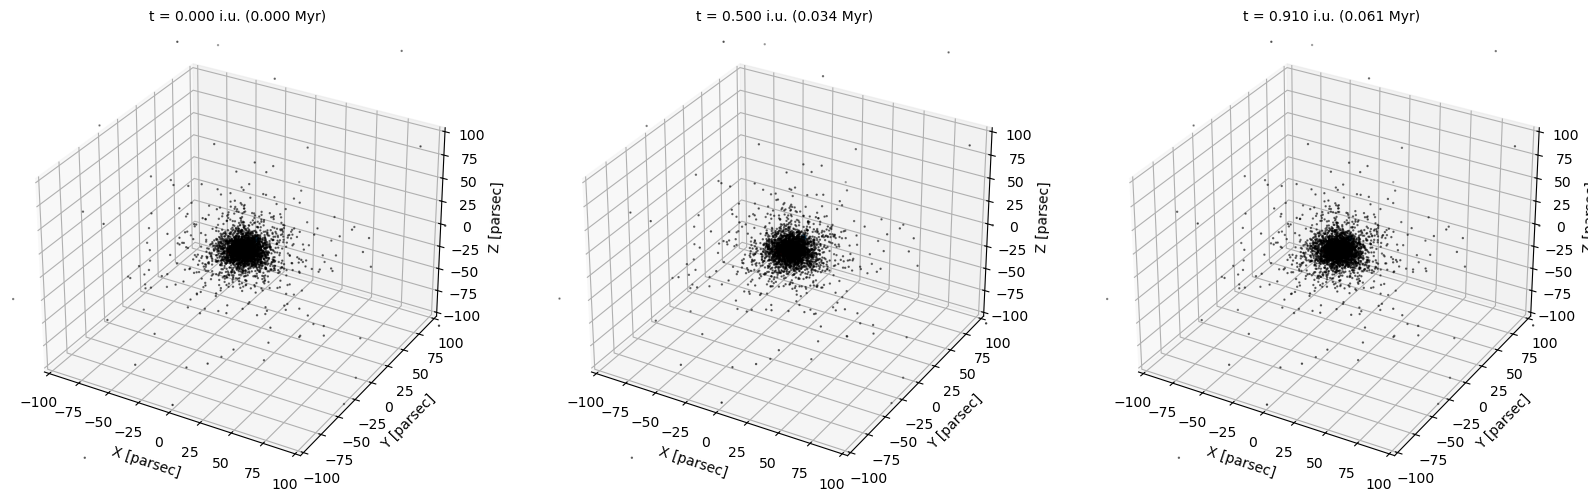

In [17]:
view(plum,r_max=100, t=[0,0.5,1])

In [18]:
show_animation(plum,r_max=10,speed=1)